In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the dataset

In [2]:
ds = pd.read_csv('CO2 Emissions_Canada.csv')
ds = ds[ds['Fuel Type'] != 'N']
ds.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
y = ds["CO2 Emissions(g/km)"]
X_orig = ds.drop(columns=["CO2 Emissions(g/km)"])

# 2. Create Transformers

In [4]:
from pyreal.transformers import Transformer, OneHotEncoder, StandardScaler, ColumnDropTransformer
from sklearn.preprocessing import OrdinalEncoder

def aggregate_transmission(df):
    df['Transmission'] = np.where(df['Transmission'].isin(['A4','A5','A6','A7','A8','A9','A10']),'Automatic',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['AS4','AS5','AS6','AS7','AS8','AS9','AS10']),'Automatic of Selective type',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['AM5','AM6','AM7','AM8','AM9']),'Automated Manual',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['AV','AV6','AV7','AV8','AV10']),'CVT',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['M5','M6','M7']),'Manual',df['Transmission'])
    return df

def rename_fuel_type(df):
    df['Fuel Type']= np.where(df['Fuel Type']=='X','Regular gasoline',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='Z','Premium gasoline',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='E','Ethanol',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='D','Diesel',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='N','Natural gas',df['Fuel Type'])
    return df

transmission_transformer = Transformer.from_transform_function(aggregate_transmission)
transmission_transformer.set_flags(model=True, interpret=True)

fuel_transformer = Transformer.from_transform_function(rename_fuel_type)
fuel_transformer.set_flags(model=True, interpret=True)

one_hot_encoder = OneHotEncoder(columns=["Fuel Type", "Transmission"])

dropper = ColumnDropTransformer(columns=["Model"])

ordinal_encoder = Transformer(OrdinalEncoder(), columns=["Make", "Vehicle Class"])

scaler = StandardScaler()

transformers = [transmission_transformer, fuel_transformer, one_hot_encoder, dropper, ordinal_encoder, scaler]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 3. Train model

In [5]:
from sklearn.model_selection import train_test_split
from pyreal.transformers import run_transformers, fit_transformers

X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.2, random_state=42)

X_train_model = fit_transformers(transformers, X_train)
X_test_model = run_transformers(transformers, X_test)

RMSE: 2.4448
MAE: 1.6587
R2_score: 0.9983


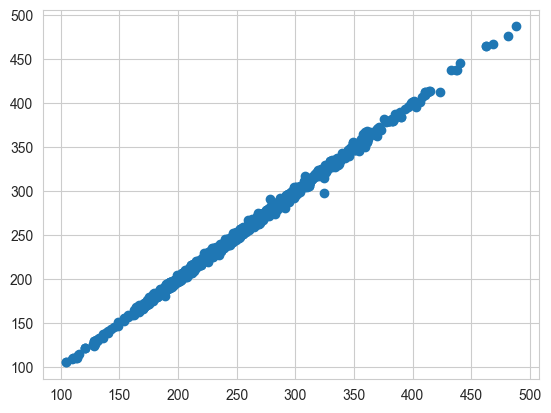

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error ,r2_score, mean_absolute_error

model = RandomForestRegressor()
model.fit(X_train_model, y_train)

preds = model.predict(X_test_model)

print('RMSE: {:0.4f}'.format(np.sqrt(mean_squared_error(y_test, preds))))
print('MAE: {:0.4f}'.format(mean_absolute_error(y_test, preds)))
print('R2_score: {:0.4f}'.format(r2_score(y_test, preds)))
plt.scatter(preds, y_test)

# 4. Make RealApp

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


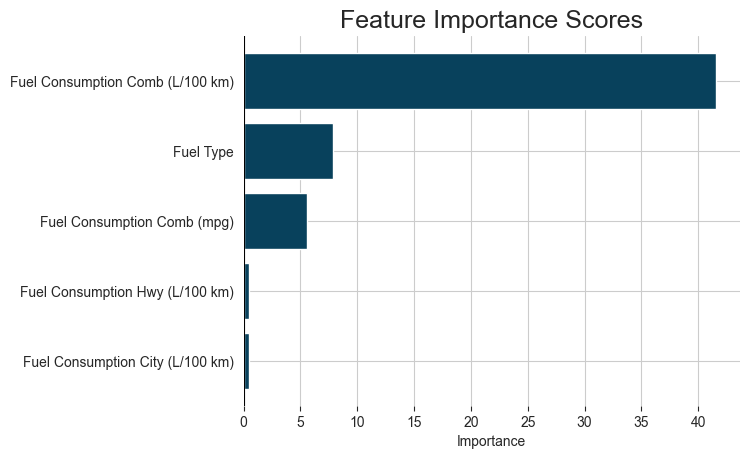

In [13]:
from pyreal import RealApp
from pyreal.visualize import feature_bar_plot
import yaml

with open('key.yaml', 'r') as file:
    key = yaml.load(file, Loader=yaml.FullLoader)['openai_key']

context_description = "The model predicts the CO2 emissions of a cars, in grams per kilometer. "
app = RealApp(model, 
              transformers=transformers, 
              X_train_orig=X_train, 
              y_train=y_train, 
              openai_api_key=key,
              context_description=context_description)

importance = app.produce_feature_importance(training_size=100)
feature_bar_plot(importance)

In [14]:
display(app.produce_feature_contributions(X_test.iloc[0]))

app.produce_narrative_feature_contributions(X_test.iloc[0])

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


,Feature Name,Feature Value,Contribution,Average/Mode
0,Make,CHEVROLET,0.242700,CHEVROLET
1,Model,Corvette ZR1,0.000000,Corvette ZR1
2,Vehicle Class,TWO-SEATER,0.163255,TWO-SEATER
3,Engine Size(L),6.2,-0.019651,6.2
4,Cylinders,8,0.115676,8
5,Fuel Consumption City (L/100 km),18.2,0.046340,18.2
6,Fuel Consumption Hwy (L/100 km),12.5,0.284092,12.5
7,Fuel Consumption Comb (L/100 km),15.6,97.465074,15.6
8,Fuel Consumption Comb (mpg),18,10.878672,18
9,Fuel Type,Premium gasoline,6.390917,Premium gasoline


DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


['The model thinks that having a fuel consumption of 15.6 L/100 km contributes the most to the predicted CO2 emissions, adding 97.47 grams per kilometer. Using premium gasoline as fuel also increases the emissions by 6.39 grams per kilometer. A fuel consumption of 18 mpg contributes 10.88 grams per kilometer. Driving on the highway with a consumption of 12.5 L/100 km adds 0.28 grams per kilometer. The car being a Chevrolet only slightly affects the emissions, adding 0.24 grams per kilometer.']